In [ ]:
#This notebook uses def sort_trials_by_CW_and_CCW_smoothed_window
#This function smooths change indices over ten time points and determines assignment (cw/ccw)
#based on the most prominent direction in the first 50 10-time-point windows (approx. 1 sec)
#Note: if the trial head angles are less than 10 a smaller window is taken

In [1]:
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), "..", ".."))
main_copy_dir = os.path.join(parent_dir, "main_copy")
benny_dev_dir = os.path.join(parent_dir, "benny_dev_dir")
sys.path.append(main_copy_dir)
sys.path.append(benny_dev_dir)

print("Added paths to sys.path:", main_copy_dir, benny_dev_dir)

Added paths to sys.path: /Users/benny/Desktop/MSc/Project/Git/repos/main_copy /Users/benny/Desktop/MSc/Project/Git/repos/benny_dev_dir


In [2]:
#imports
%load_ext autoreload
%autoreload 2
import scipy
import parse_data.prepare_data as prepare_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import globals
import plotting.plot_trajectory as plot_trajectory
import plotting.plot_octagon as plot_octagon
import data_extraction.extract_trial as extract_trial
import math
import trajectory_analysis.trajectory_vectors as trajectory_vectors
import trajectory_analysis.trajectory_headangle as trajectory_headangle
from IPython.display import Image, display
import data_extraction.get_indices as get_indices
import prominent_direction_functions as prominent_direction_functions
import flip_rotate_headangle_functions
import headangle_analysis_plotting_functions
import headangle_bin_assignment_new
import analysis.wall_visibility_and_choice as wall_visibility_and_choice
import calculate_probabilities_functions

In [3]:
data_folder = '/Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis'

json_filenames_all_social = [r'Json_data/2024-11-19_15-22-56_SophiaHocineSocial.json',
                                r'Json_data/2024-11-12_13-31-14_KhadijaWendySocial.json', 
                                r'Json_data/2024-12-19_15-28-24_JingjingYeungSocial.json', 
                                r'Json_data/2024-10-17_16-41-38_ZimoElsaSocial.json', 
                                r'Json_data/2025-01-15_15-21-27_YixuanMarcoSocial.json',
                                r'Json_data/2024-11-13_14-18-54_NasiaRyanSocial.json', 
                                r'Json_data/2024-11-19_14-24-49_AmyXinyuanSocial.json', 
                                r'Json_data/2024-09-27_14-25-20_SaraEmilySocial.json', 
                                r'Json_data/2024-11-13_15-28-07_YichuanHoiSocial.json', 
                                r'Json_data/2024-11-20_15-16-21_SunnyVinceSocial.json', 
                                r'Json_data/2025-01-15_16-50-13_YuChunSecondSocial.json', 
                                r'Json_data/2024-11-12_15-23-24_FrancescaSenSzeSocial.json', 
                                r'Json_data/2024-10-17_14-28-40_ShamirAbigailSocial.json',
                                r'Json_data/2024-09-13_11-31-00_YansuJerrySocial.json', 
                                r'Json_data/2024-11-20_14-17-44_JasonRahulSocial.json']
 
json_filenames_all_solo = [r'Json_data/2024-12-20_17-36-54_ChristopherFirstSolo.json',
                                r'Json_data/2025-01-15_15-12-39_MarcoFirstSolo.json',
                                r'Json_data/2024-12-19_15-51-33_YeungSecondSolo.json',
                                r'Json_data/2024-11-12_15-44-54_FrancescaSecondSolo.json',
                                r'Json_data/2024-11-12_15-11-45_SenFirstSolo.json',
                                r'Json_data/2024-11-20_15-39-49_VinceSecondSolo.json',
                                r'Json_data/2024-11-19_14-18-18_AmyFirstSolo.json',
                                r'Json_data/2024-11-12_15-45-35_SenSecondSolo.json',
                                r'Json_data/2024-11-12_13-50-23_KhadijaSecondSolo.json',
                                r'Json_data/2024-11-13_15-21-50_HoiFirstSolo.json',
                                r'Json_data/2024-09-13_11-23-37_YansuFirstSolo.json',
                                r'Json_data/2024-11-13_15-22-20_YichuanFirstSolo.json',
                                r'Json_data/2024-11-20_15-10-17_VinceFirstSolo.json',
                                r'Json_data/2025-01-15_16-14-40_YuChunFirstSolo.json',
                                r'Json_data/2024-11-12_13-18-59_WendyFirstSolo.json',
                                r'Json_data/2024-10-17_14-51-22_AbigailSecondSolo.json',
                                r'Json_data/2024-09-13_11-53-56_JerrySecondSolo.json',
                                r'Json_data/2024-09-27_14-14-42_EmilyFirstSolo.json',
                                r'Json_data/2025-01-15_16-50-13_YuChunSecondSolo.json',
                                r'Json_data/2024-11-12_13-50-20_WendySecondSolo.json',
                                r'Json_data/2025-01-15_15-46-04_MarcoSecondSolo.json',
                                r'Json_data/2024-10-17_14-20-50_AbigailFirstSolo.json',
                                r'Json_data/2024-11-13_15-51-39_YichuanSecondSolo.json',
                                r'Json_data/2024-11-20_14-41-56_RahulSecondSolo.json',
                                r'Json_data/2024-10-17_14-20-28_ShamirFirstSolo.json',
                                r'Json_data/2025-01-15_15-47-11_YixuanSecondSolo.json',
                                r'Json_data/2024-11-19_15-15-53_SophiaFirstSolo.json',
                                r'Json_data/2025-01-15_16-50-37_RuiqingSecondSolo.json',
                                r'Json_data/2024-11-20_15-40-08_SunnySecondSolo.json',
                                r'Json_data/2024-09-27_14-14-31_SaraFirstSolo.json',
                                r'Json_data/2024-09-27_14-45-46_EmilySecondSolo.json',
                                r'Json_data/2024-11-12_13-19-22_KhadijaFirstSolo.json',
                                r'Json_data/2024-11-12_15-13-34_FrancescaFirstSolo.json',
                                r'Json_data/2024-11-19_15-47-53_SophiaSecondSolo.json',
                                r'Json_data/2024-11-20_14-12-33_RahulFirstSolo.json',
                                r'Json_data/2024-10-17_14-50-03_ShamirSecondSolo.json',
                                r'Json_data/2024-09-13_11-53-34_YansuSecondSolo.json',
                                r'Json_data/2024-10-17_17-12-29_ElsaSecondSolo.json',
                                r'Json_data/2024-12-19_15-22-13_YeungFirstSolo.json',
                                r'Json_data/2024-12-19_15-51-58_JingjingSecondSolo.json',
                                r'Json_data/2024-11-13_15-51-16_HoiSecondSolo.json',
                                r'Json_data/2024-11-19_14-18-44_XinyuanFirstSolo.json',
                                r'Json_data/2024-12-20_18-06-44_ChristopherSecondSolo.json',
                                r'Json_data/2024-10-17_16-35-45_ElsaFirstSolo.json',
                                r'Json_data/2024-11-20_15-10-00_SunnyFirstSolo.json',
                                r'Json_data/2024-11-19_14-44-31_XinyuanSecondSolo.json',
                                r'Json_data/2024-11-20_14-12-06_JasonFirstSolo.json',
                                r'Json_data/2024-12-20_17-36-27_KirtanFirstSolo.json',
                                r'Json_data/2024-10-17_16-36-0_ZimoFirstSolo.json',
                                r'Json_data/2024-09-27_14-45-55_SaraSecondSolo.json',
                                r'Json_data/2024-10-17_17-11-46_ZimoSecondSolo.json',
                                r'Json_data/2024-12-20_18-06-10_KirtanSecondSolo.json',
                                r'Json_data/2025-01-15_16-14-58_RuiqingFirstSolo.json',
                                r'Json_data/2024-11-19_15-14-19_HocineFirstSolo.json',
                                r'Json_data/2024-11-20_14-42-16_JasonSecondSolo.json',
                                r'Json_data/2024-12-19_15-20-18_JingjingFirstSolo.json',
                                r'Json_data/2024-09-13_11-23-50_JerryFirstSolo.json',
                                r'Json_data/2025-01-15_15-12-13_YixuanFirstSolo.json',
                                r'Json_data/2024-11-19_15-47-29_HocineSecondSolo.json',
                                r'Json_data/2024-11-19_14-44-00_AmySecondSolo.json']

json_filename = r'Json_data/2024-11-12_13-50-23_KhadijaSecondSolo.json'


                             

In [ ]:
#prepare solos
dfs, solo_list = prepare_data.prepare_combined_session_data(data_folder, json_filenames_all_solo)

In [4]:
#prepare socials
df, trial_list = prepare_data.prepare_combined_session_data(data_folder, json_filenames_all_social)

filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-11-19_15-22-56_SophiaHocineSocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-11-12_13-31-14_KhadijaWendySocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-12-19_15-28-24_JingjingYeungSocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-10-17_16-41-38_ZimoElsaSocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2025-01-15_15-21-27_YixuanMarcoSocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-11-13_14-18-54_NasiaRyanSocial.json
Loading complete.
filepath: /Users/benny/Desktop/MSc/Project/Git/repos_backup/octagon_analysis/Json_data/2024-11-19_14-24-49_AmyXin

In [44]:
headangle_array = np.array(trajectory_vectors.extract_trial_player_headangles(trial=trial_list[1], player_id=0))


In [49]:
testing = prominent_direction_functions.get_change_indices_smoothed_windows(headangle_array, 10)

In [65]:
CCW_player_0, CW_player_0 = prominent_direction_functions.sort_trials_by_CW_and_CCW_smoothed_window(trial_list, 0, 10)

Taking less steps for 11, headangles length: 5, steps: 2
Taking less steps for 94, headangles length: 3, steps: 1
Taking less steps for 191, headangles length: 2, steps: 1
Trial number 213 is empty
Taking less steps for 221, headangles length: 8, steps: 4
Taking less steps for 1010, headangles length: 4, steps: 2
Taking less steps for 1020, headangles length: 3, steps: 1
Taking less steps for 1094, headangles length: 4, steps: 2
Taking less steps for 1321, headangles length: 2, steps: 1
Taking less steps for 1335, headangles length: 4, steps: 2
Taking less steps for 1447, headangles length: 4, steps: 2
Taking less steps for 1455, headangles length: 6, steps: 3
Trial number 1523 is empty
Trial number 1531 is empty
Taking less steps for 1536, headangles length: 2, steps: 1
Trial number 1548 is empty


In [68]:
len(trial_list)

1839

In [69]:
CCW_player_1, CW_player_1 = prominent_direction_functions.sort_trials_by_CW_and_CCW_smoothed_window(trial_list, 1, 10)

Taking less steps for 11, headangles length: 5, steps: 2
Taking less steps for 94, headangles length: 3, steps: 1
Taking less steps for 191, headangles length: 2, steps: 1
Trial number 213 is empty
Taking less steps for 221, headangles length: 8, steps: 4
Taking less steps for 1010, headangles length: 4, steps: 2
Taking less steps for 1020, headangles length: 3, steps: 1
Taking less steps for 1094, headangles length: 4, steps: 2
Taking less steps for 1321, headangles length: 2, steps: 1
Taking less steps for 1335, headangles length: 4, steps: 2
Taking less steps for 1447, headangles length: 4, steps: 2
Taking less steps for 1455, headangles length: 6, steps: 3
Trial number 1523 is empty
Trial number 1531 is empty
Taking less steps for 1536, headangles length: 2, steps: 1
Trial number 1548 is empty


In [70]:

#High-Low
ccw_indices0 = get_indices.get_trials_trialtype(CCW_player_0, trial_type=globals.HIGH_LOW)
ccw_0 = [CCW_player_0[i] for i in ccw_indices0]

ccw_indices1 = get_indices.get_trials_trialtype(CCW_player_1, trial_type=globals.HIGH_LOW)
ccw_1 = [CCW_player_1[i] for i in ccw_indices1]

cw_indices0 = get_indices.get_trials_trialtype(CW_player_0, trial_type=globals.HIGH_LOW)
cw_0 = [CW_player_0[i] for i in cw_indices0]

cw_indices1 = get_indices.get_trials_trialtype(CW_player_1, trial_type=globals.HIGH_LOW)
cw_1 = [CW_player_1[i] for i in cw_indices1]

#45° wall separation
single_sep_ccw0 = get_indices.get_trials_with_wall_sep(ccw_0, wall_sep=1)
ccw_0_45 = [ccw_0[i] for i in single_sep_ccw0]

single_sep_ccw1 = get_indices.get_trials_with_wall_sep(ccw_1, wall_sep=1)
ccw_1_45 = [ccw_1[i] for i in single_sep_ccw1]

single_sep_cw0 = get_indices.get_trials_with_wall_sep(cw_0, wall_sep=1)
cw_0_45 = [cw_0[i] for i in single_sep_cw0]

single_sep_cw1 = get_indices.get_trials_with_wall_sep(cw_1, wall_sep=1)
cw_1_45 = [cw_1[i] for i in single_sep_cw1]

#90° wall separation
two_sep_ccw0 = get_indices.get_trials_with_wall_sep(ccw_0, wall_sep=2)
ccw_0_90 = [ccw_0[i] for i in single_sep_ccw0]

two_sep_ccw1 = get_indices.get_trials_with_wall_sep(ccw_1, wall_sep=2)
ccw_1_90 = [ccw_1[i] for i in single_sep_ccw1]

two_sep_cw0 = get_indices.get_trials_with_wall_sep(cw_0, wall_sep=2)
cw_0_90 = [cw_0[i] for i in single_sep_cw0]

two_sep_cw1 = get_indices.get_trials_with_wall_sep(cw_1, wall_sep=2)
cw_1_90 = [cw_1[i] for i in single_sep_cw1]

#180° wall separation
four_sep_ccw0 = get_indices.get_trials_with_wall_sep(ccw_0, wall_sep=4)
ccw_0_180 = [ccw_0[i] for i in single_sep_ccw0]

four_sep_ccw1 = get_indices.get_trials_with_wall_sep(ccw_1, wall_sep=4)
ccw_1_180 = [ccw_1[i] for i in single_sep_ccw1]

four_sep_cw0 = get_indices.get_trials_with_wall_sep(cw_0, wall_sep=4)
cw_0_180 = [cw_0[i] for i in single_sep_cw0]

four_sep_cw1 = get_indices.get_trials_with_wall_sep(cw_1, wall_sep=4)
cw_1_180 = [cw_1[i] for i in single_sep_cw1]


In [71]:
#take whole trial list and update yaw & trajectory for both players
#45
updated_ccw_1_45 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_1_45)

In [72]:
updated_ccw_0_45 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_0_45)

In [73]:
updated_cw_1_45 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_1_45)

In [74]:
updated_cw_0_45 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_0_45)

In [75]:
#90
updated_ccw_1_90 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_1_90)

In [76]:
updated_ccw_0_90 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_0_90)

In [77]:
updated_cw_1_90 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_1_90)

In [78]:
updated_cw_0_90 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_0_90)

In [79]:
#180
updated_ccw_1_180 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_1_180)

In [80]:
updated_ccw_0_180 = flip_rotate_headangle_functions.process_and_update_trials_both_players(ccw_0_180)

In [81]:
updated_cw_1_180 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_1_180)

In [82]:
updated_cw_0_180 = flip_rotate_headangle_functions.process_and_update_trials_both_players(cw_0_180)

In [83]:
#bin assignments for the whole trial list
#45
bins_45_1_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_1_45)[1]
bins_45_0_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_0_45)[0]
bins_45_1_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_1_45)[1]
bins_45_0_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_0_45)[0]


In [84]:
#90
bins_90_1_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_1_90)[1]
bins_90_0_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_0_90)[0]
bins_90_1_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_1_90)[1]
bins_90_0_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_0_90)[0]


In [85]:
#180
bins_180_1_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_1_180)[1]
bins_180_0_ccw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_ccw_0_180)[0]
bins_180_1_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_1_180)[1]
bins_180_0_cw = headangle_bin_assignment_new.assign_bins_to_all_trials(updated_cw_0_180)[0]

In [89]:
#get player wall choices from original trial list for both losses and wins
#45
choice_45_0_ccw = wall_visibility_and_choice.get_player_wall_choice(ccw_0_45, 0, inferred_choice=False, debug=True)
choice_45_1_ccw  = wall_visibility_and_choice.get_player_wall_choice(ccw_1_45, 1, inferred_choice=False, debug=True)
choice_45_0_cw = wall_visibility_and_choice.get_player_wall_choice(cw_0_45, 0, inferred_choice=False, debug=True)
choice_45_1_cw  = wall_visibility_and_choice.get_player_wall_choice(cw_1_45, 1, inferred_choice=False, debug=True)

Time taken for player_wall_choice_wins_only (one session for one player) is 1.12
include loser's inferred choice status: False
player wall choices for this player: [nan  5.  8.  2.  7.  7. nan  1.  3. nan  6.  2.  3. nan  8. nan  4. nan
 nan nan  3. nan nan nan  6.  6. nan  3.  1. nan  1.  6.  6. nan nan nan
 nan nan  6. nan nan nan nan nan nan nan nan nan  5.  4.  8. nan  8.  5.
 nan nan nan nan nan nan nan nan  4. nan  4. nan nan  8. nan nan nan nan
 nan nan nan  7. nan  8. nan nan  1.  7.  8. nan  4.  8.  1. nan nan nan
 nan nan nan nan  5.  7. nan nan nan nan  2. nan nan  6. nan  8. nan nan
 nan nan nan nan  7. nan  2. nan  8.  4.  7. nan nan nan nan  3. nan  7.
  2. nan nan  1. nan  5.  3. nan  6.  5. nan nan  6.  3. nan nan nan nan
 nan nan  2. nan  2. nan  3. nan nan  8.  7.  4.  3.  6.  8.  4.  5.  5.
  8. nan  5. nan nan  1.  3. nan nan  1.  5.  6.  1. nan nan nan nan  1.
 nan  3. nan nan  5.  2.  2.  5.  8.  1.  1. nan nan nan  6.  6. nan nan
 nan nan  1. nan nan  4.  1.  4. 

In [88]:
#90
choice_90_0_ccw = wall_visibility_and_choice.get_player_wall_choice(ccw_0_90, 0, inferred_choice=False, debug=True)
choice_90_1_ccw  = wall_visibility_and_choice.get_player_wall_choice(ccw_1_90, 1, inferred_choice=False, debug=True)
choice_90_0_cw = wall_visibility_and_choice.get_player_wall_choice(cw_0_90, 0, inferred_choice=False, debug=True)
choice_90_1_cw  = wall_visibility_and_choice.get_player_wall_choice(cw_1_90, 1, inferred_choice=False, debug=True)

Time taken for player_wall_choice_wins_only (one session for one player) is 0.84
include loser's inferred choice status: False
player wall choices for this player: [nan  5.  8.  2.  7.  7. nan  1.  3. nan  6.  2.  3. nan  8. nan  4. nan
 nan nan  3. nan nan nan  6.  6. nan  3.  1. nan  1.  6.  6. nan nan nan
 nan nan  6. nan nan nan nan nan nan nan nan nan  5.  4.  8. nan  8.  5.
 nan nan nan nan nan nan nan nan  4. nan  4. nan nan  8. nan nan nan nan
 nan nan nan  7. nan  8. nan nan  1.  7.  8. nan  4.  8.  1. nan nan nan
 nan nan nan nan  5.  7. nan nan nan nan  2. nan nan  6. nan  8. nan nan
 nan nan nan nan  7. nan  2. nan  8.  4.  7. nan nan nan nan  3. nan  7.
  2. nan nan  1. nan  5.  3. nan  6.  5. nan nan  6.  3. nan nan nan nan
 nan nan  2. nan  2. nan  3. nan nan  8.  7.  4.  3.  6.  8.  4.  5.  5.
  8. nan  5. nan nan  1.  3. nan nan  1.  5.  6.  1. nan nan nan nan  1.
 nan  3. nan nan  5.  2.  2.  5.  8.  1.  1. nan nan nan  6.  6. nan nan
 nan nan  1. nan nan  4.  1.  4. 

In [90]:
#180
choice_180_0_ccw = wall_visibility_and_choice.get_player_wall_choice(ccw_0_180, 0, inferred_choice=False, debug=True)
choice_180_1_ccw  = wall_visibility_and_choice.get_player_wall_choice(ccw_1_180, 1, inferred_choice=False, debug=True)
choice_180_0_cw = wall_visibility_and_choice.get_player_wall_choice(cw_0_180, 0, inferred_choice=False, debug=True)
choice_180_1_cw  = wall_visibility_and_choice.get_player_wall_choice(cw_1_180, 1, inferred_choice=False, debug=True)

Time taken for player_wall_choice_wins_only (one session for one player) is 0.47
include loser's inferred choice status: False
player wall choices for this player: [nan  5.  8.  2.  7.  7. nan  1.  3. nan  6.  2.  3. nan  8. nan  4. nan
 nan nan  3. nan nan nan  6.  6. nan  3.  1. nan  1.  6.  6. nan nan nan
 nan nan  6. nan nan nan nan nan nan nan nan nan  5.  4.  8. nan  8.  5.
 nan nan nan nan nan nan nan nan  4. nan  4. nan nan  8. nan nan nan nan
 nan nan nan  7. nan  8. nan nan  1.  7.  8. nan  4.  8.  1. nan nan nan
 nan nan nan nan  5.  7. nan nan nan nan  2. nan nan  6. nan  8. nan nan
 nan nan nan nan  7. nan  2. nan  8.  4.  7. nan nan nan nan  3. nan  7.
  2. nan nan  1. nan  5.  3. nan  6.  5. nan nan  6.  3. nan nan nan nan
 nan nan  2. nan  2. nan  3. nan nan  8.  7.  4.  3.  6.  8.  4.  5.  5.
  8. nan  5. nan nan  1.  3. nan nan  1.  5.  6.  1. nan nan nan nan  1.
 nan  3. nan nan  5.  2.  2.  5.  8.  1.  1. nan nan nan  6.  6. nan nan
 nan nan  1. nan nan  4.  1.  4. 

In [91]:
#check whether high wall was chosen
#45
high_wall_chosen_45_ccw_0 = get_indices.was_given_wall_chosen(ccw_0_45, choice_45_0_ccw, 0)
high_wall_chosen_45_ccw_1 = get_indices.was_given_wall_chosen(ccw_1_45, choice_45_1_ccw, 0)
high_wall_chosen_45_cw_0 = get_indices.was_given_wall_chosen(cw_0_45, choice_45_0_cw, 0)
high_wall_chosen_45_cw_1 = get_indices.was_given_wall_chosen(cw_1_45, choice_45_1_cw, 0)


In [92]:
high_wall_chosen_90_ccw_0 = get_indices.was_given_wall_chosen(ccw_0_90, choice_90_0_ccw, 0)
high_wall_chosen_90_ccw_1 = get_indices.was_given_wall_chosen(ccw_1_90, choice_90_1_ccw, 0)
high_wall_chosen_90_cw_0 = get_indices.was_given_wall_chosen(cw_0_90, choice_90_0_cw, 0)
high_wall_chosen_90_cw_1 = get_indices.was_given_wall_chosen(cw_1_90, choice_90_1_cw, 0)


In [93]:
high_wall_chosen_180_ccw_0 = get_indices.was_given_wall_chosen(ccw_0_180, choice_180_0_ccw, 0)
high_wall_chosen_180_ccw_1 = get_indices.was_given_wall_chosen(ccw_1_180, choice_180_1_ccw, 0)
high_wall_chosen_180_cw_0 = get_indices.was_given_wall_chosen(cw_0_180, choice_180_0_cw, 0)
high_wall_chosen_180_cw_1 = get_indices.was_given_wall_chosen(cw_1_180, choice_180_1_cw, 0)


In [94]:
probabilities_45_ccw_dict, probabilities_list_45_ccw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_45_0_ccw,bins_45_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_45_ccw_0,high_wall_chosen_45_ccw_1], 
    debug=True
)

probabilities_45_cw_dict, probabilities_list_45_cw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_45_0_cw,bins_45_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_45_cw_0,high_wall_chosen_45_cw_1], 
    debug=True
)

[0.975609756097561, 0.813953488372093, 0.5454545454545454, 0.6363636363636364, 0.875, 0.9523809523809523, 1.0, 1.0]
Bin 1: 0.98 (True/Total = 40/41)
Bin 2: 0.81 (True/Total = 35/43)
Bin 3: 0.55 (True/Total = 24/44)
Bin 4: 0.64 (True/Total = 14/22)
Bin 5: 0.88 (True/Total = 14/16)
Bin 6: 0.95 (True/Total = 20/21)
Bin 7: 1.00 (True/Total = 18/18)
Bin 8: 1.00 (True/Total = 45/45)
[0.918918918918919, 0.8311688311688312, 0.5416666666666666, 0.75, 0.75, 0.8518518518518519, 0.9482758620689655, 0.921875]
Bin 1: 0.92 (True/Total = 68/74)
Bin 2: 0.83 (True/Total = 64/77)
Bin 3: 0.54 (True/Total = 26/48)
Bin 4: 0.75 (True/Total = 27/36)
Bin 5: 0.75 (True/Total = 33/44)
Bin 6: 0.85 (True/Total = 23/27)
Bin 7: 0.95 (True/Total = 55/58)
Bin 8: 0.92 (True/Total = 59/64)


In [95]:
probabilities_90_ccw_dict, probabilities_list_90_ccw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_90_0_ccw,bins_90_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_90_ccw_0,high_wall_chosen_90_ccw_1], 
    debug=True
)

probabilities_90_cw_dict, probabilities_list_90_cw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_90_0_cw,bins_90_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_90_cw_0,high_wall_chosen_90_cw_1], 
    debug=True
)

[0.975609756097561, 0.813953488372093, 0.5454545454545454, 0.6363636363636364, 0.875, 0.9523809523809523, 1.0, 1.0]
Bin 1: 0.98 (True/Total = 40/41)
Bin 2: 0.81 (True/Total = 35/43)
Bin 3: 0.55 (True/Total = 24/44)
Bin 4: 0.64 (True/Total = 14/22)
Bin 5: 0.88 (True/Total = 14/16)
Bin 6: 0.95 (True/Total = 20/21)
Bin 7: 1.00 (True/Total = 18/18)
Bin 8: 1.00 (True/Total = 45/45)
[0.918918918918919, 0.8311688311688312, 0.5416666666666666, 0.75, 0.75, 0.8518518518518519, 0.9482758620689655, 0.921875]
Bin 1: 0.92 (True/Total = 68/74)
Bin 2: 0.83 (True/Total = 64/77)
Bin 3: 0.54 (True/Total = 26/48)
Bin 4: 0.75 (True/Total = 27/36)
Bin 5: 0.75 (True/Total = 33/44)
Bin 6: 0.85 (True/Total = 23/27)
Bin 7: 0.95 (True/Total = 55/58)
Bin 8: 0.92 (True/Total = 59/64)


In [96]:
probabilities_180_ccw_dict, probabilities_list_180_ccw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_180_0_ccw,bins_180_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_180_ccw_0,high_wall_chosen_180_ccw_1], 
    debug=True
)

probabilities_180_cw_dict, probabilities_list_180_cw = calculate_probabilities_functions.calculate_high_wall_probabilities(
    bin_assignments_lists=[bins_180_0_cw,bins_180_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_180_cw_0,high_wall_chosen_180_cw_1], 
    debug=True
)

[0.975609756097561, 0.813953488372093, 0.5454545454545454, 0.6363636363636364, 0.875, 0.9523809523809523, 1.0, 1.0]
Bin 1: 0.98 (True/Total = 40/41)
Bin 2: 0.81 (True/Total = 35/43)
Bin 3: 0.55 (True/Total = 24/44)
Bin 4: 0.64 (True/Total = 14/22)
Bin 5: 0.88 (True/Total = 14/16)
Bin 6: 0.95 (True/Total = 20/21)
Bin 7: 1.00 (True/Total = 18/18)
Bin 8: 1.00 (True/Total = 45/45)
[0.918918918918919, 0.8311688311688312, 0.5416666666666666, 0.75, 0.75, 0.8518518518518519, 0.9482758620689655, 0.921875]
Bin 1: 0.92 (True/Total = 68/74)
Bin 2: 0.83 (True/Total = 64/77)
Bin 3: 0.54 (True/Total = 26/48)
Bin 4: 0.75 (True/Total = 27/36)
Bin 5: 0.75 (True/Total = 33/44)
Bin 6: 0.85 (True/Total = 23/27)
Bin 7: 0.95 (True/Total = 55/58)
Bin 8: 0.92 (True/Total = 59/64)


In [97]:
overall_probability_45_ccw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_45_0_ccw,bins_45_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_45_ccw_0,high_wall_chosen_45_ccw_1], 
)

overall_probability_45_cw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_45_0_cw,bins_45_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_45_cw_0,high_wall_chosen_45_cw_1], 
)

In [98]:
print(overall_probability_45_cw)

0.8294392523364486


In [99]:
overall_probability_90_ccw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_90_0_ccw,bins_90_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_90_ccw_0,high_wall_chosen_90_ccw_1], 
)

overall_probability_90_cw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_90_0_cw,bins_90_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_90_cw_0,high_wall_chosen_90_cw_1], 
)

In [100]:
overall_probability_180_ccw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_180_0_ccw,bins_180_1_ccw], 
    high_wall_chosen_lists=[high_wall_chosen_180_ccw_0,high_wall_chosen_180_ccw_1], 
)

overall_probability_180_cw = calculate_probabilities_functions.calculate_p_high(
    bin_assignments_lists=[bins_180_0_cw,bins_180_1_cw], 
    high_wall_chosen_lists=[high_wall_chosen_180_cw_0,high_wall_chosen_180_cw_1], 
)

In [101]:
#obtain difference between p(H) given bin and average p(H)
new_probabilities_list_45_ccw = [probability - overall_probability_45_ccw for probability in probabilities_list_45_ccw]
new_probabilities_list_45_cw = [probability - overall_probability_45_cw for probability in probabilities_list_45_cw]

new_probabilities_list_90_ccw = [probability - overall_probability_90_ccw for probability in probabilities_list_90_ccw]
new_probabilities_list_90_cw = [probability - overall_probability_90_cw for probability in probabilities_list_90_cw]

new_probabilities_list_180_ccw = [probability - overall_probability_180_ccw for probability in probabilities_list_180_ccw]
new_probabilities_list_180_cw = [probability - overall_probability_180_cw for probability in probabilities_list_180_cw]


In [102]:
bin_ranges = headangle_bin_assignment_new.define_45_degree_bins()
print(bin_ranges)

[(np.float64(5.8904862254808625), np.float64(0.3926990816987242)), (np.float64(0.39269908169872414), np.float64(1.1780972450961724)), (np.float64(1.1780972450961726), np.float64(1.963495408493621)), (np.float64(1.9634954084936211), np.float64(2.7488935718910694)), (np.float64(2.748893571891069), np.float64(3.5342917352885173)), (np.float64(3.5342917352885173), np.float64(4.319689898685965)), (np.float64(4.319689898685965), np.float64(5.105088062083414)), (np.float64(5.105088062083414), np.float64(5.890486225480862))]


(2, 8)


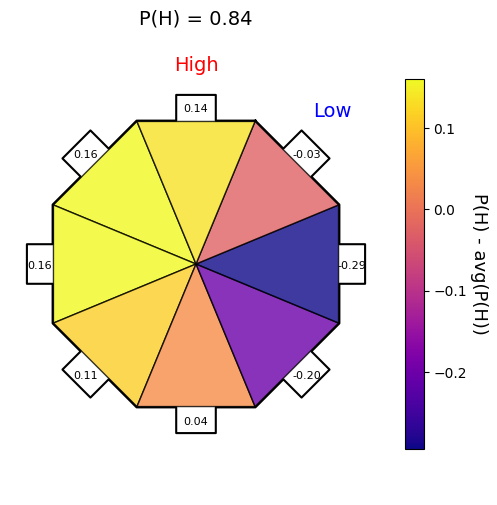

[0.13560975609756099, -0.026046511627906943, -0.29454545454545455, -0.20363636363636362, 0.03500000000000003, 0.11238095238095236, 0.16000000000000003, 0.16000000000000003]


In [103]:
#45ccw
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))

#plot octagon
ax = plot_octagon.plot_octagon(ax=ax)

#define bin_ranges
bin_ranges = bin_ranges


#define ratios list
#probabilities_list_reversed = probabilities_list[::-1]

#color the segments of the octagon
ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_45_ccw)

#plot the ratios under the alcoves
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_45_ccw)

#add wall labels
alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center2_x, alcove_center2_y = alcove_centers[:,1]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center2_x + 3, alcove_center2_y + 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_45_ccw), vmin=min(new_probabilities_list_45_ccw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_45_ccw = round(overall_probability_45_ccw, 2)
plt.title(f"P(H) = {rounded_prob_45_ccw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_45_ccw)

(2, 8)


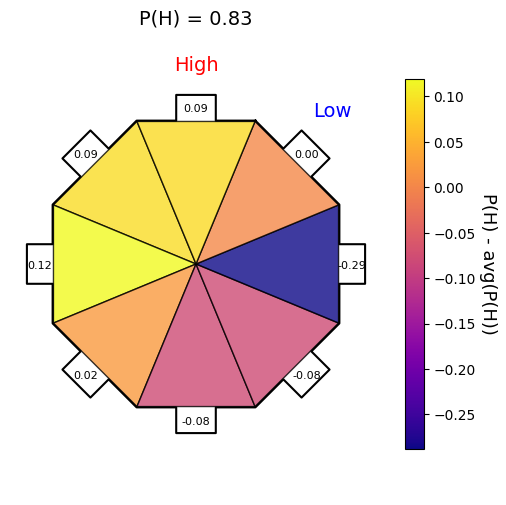

[0.08947966658247042, 0.0017295788323826722, -0.2877725856697819, -0.07943925233644855, -0.07943925233644855, 0.02241259951540331, 0.11883660973251697, 0.09243574766355145]


In [104]:
#45cw
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))
ax = plot_octagon.plot_octagon(ax=ax)
bin_ranges = bin_ranges

ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_45_cw)
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_45_cw)

alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center2_x, alcove_center2_y = alcove_centers[:,1]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center2_x + 3, alcove_center2_y + 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')


sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_45_cw), vmin=min(new_probabilities_list_45_cw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_45_cw = round(overall_probability_45_cw, 2)
plt.title(f"P(H) = {rounded_prob_45_cw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_45_cw)

(2, 8)


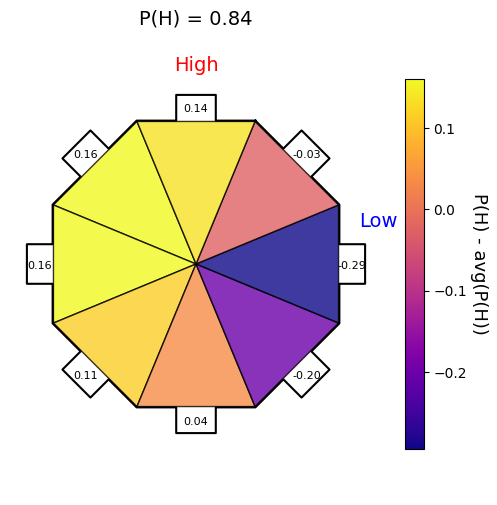

[0.13560975609756099, -0.026046511627906943, -0.29454545454545455, -0.20363636363636362, 0.03500000000000003, 0.11238095238095236, 0.16000000000000003, 0.16000000000000003]


In [105]:
#90
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))
ax = plot_octagon.plot_octagon(ax=ax)

bin_ranges = bin_ranges

ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_90_ccw)
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_90_ccw)

alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center3_x, alcove_center3_y = alcove_centers[:,2]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center3_x + 3, alcove_center3_y + 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_90_ccw), vmin=min(new_probabilities_list_90_ccw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_90_ccw = round(overall_probability_90_ccw, 2)
plt.title(f"P(H) = {rounded_prob_90_ccw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_90_ccw)

(2, 8)


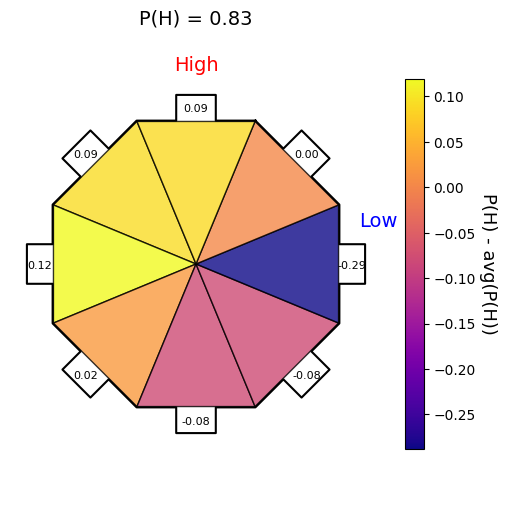

[0.08947966658247042, 0.0017295788323826722, -0.2877725856697819, -0.07943925233644855, -0.07943925233644855, 0.02241259951540331, 0.11883660973251697, 0.09243574766355145]


In [106]:
#90cw
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))
ax = plot_octagon.plot_octagon(ax=ax)

bin_ranges = bin_ranges

ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_90_cw)
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_90_cw)

alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center3_x, alcove_center3_y = alcove_centers[:,2]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center3_x + 3, alcove_center3_y + 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_90_cw), vmin=min(new_probabilities_list_90_cw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_90_cw = round(overall_probability_90_cw, 2)
plt.title(f"P(H) = {rounded_prob_90_cw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_90_cw)

(2, 8)


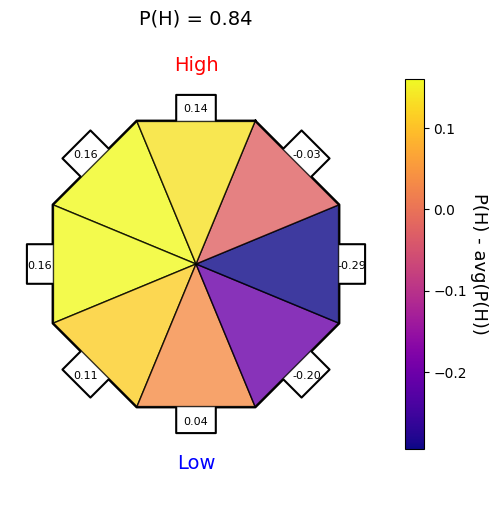

[0.13560975609756099, -0.026046511627906943, -0.29454545454545455, -0.20363636363636362, 0.03500000000000003, 0.11238095238095236, 0.16000000000000003, 0.16000000000000003]


In [107]:
#180
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))

#plot octagon
ax = plot_octagon.plot_octagon(ax=ax)

#define bin_ranges
bin_ranges = bin_ranges


#define ratios list
#probabilities_list_reversed = probabilities_list[::-1]

#color the segments of the octagon
ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_180_ccw)

#plot the ratios under the alcoves
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_180_ccw)

#add wall labels
alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center4_x, alcove_center4_y = alcove_centers[:,4]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center4_x, alcove_center4_y - 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_180_ccw), vmin=min(new_probabilities_list_180_ccw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_180_ccw = round(overall_probability_180_ccw, 2)
plt.title(f"P(H) = {rounded_prob_180_ccw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_180_ccw)

(2, 8)


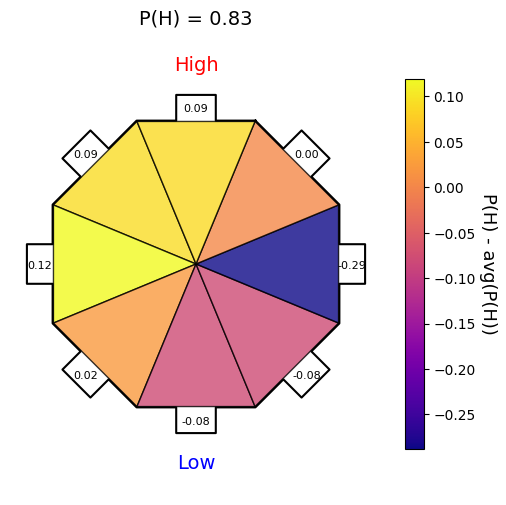

[0.08947966658247042, 0.0017295788323826722, -0.2877725856697819, -0.07943925233644855, -0.07943925233644855, 0.02241259951540331, 0.11883660973251697, 0.09243574766355145]


In [108]:
#180
#plot color gradient octagon for new ratios list

fig, ax = plt.subplots(figsize=(6, 6))

#plot octagon
ax = plot_octagon.plot_octagon(ax=ax)

#define bin_ranges
bin_ranges = bin_ranges


#define ratios list
#probabilities_list_reversed = probabilities_list[::-1]

#color the segments of the octagon
ax = headangle_analysis_plotting_functions.plot_colored_octagon(ax, bin_ranges, new_probabilities_list_180_cw)

#plot the ratios under the alcoves
ax = headangle_analysis_plotting_functions.plot_ratios_under_alcoves(ax, new_probabilities_list_180_cw)

#add wall labels
alcove_centers = plot_octagon.return_alcove_centre_points()

alcove_center1_x, alcove_center1_y = alcove_centers[:,0]
alcove_center4_x, alcove_center4_y = alcove_centers[:,4]

ax.text(alcove_center1_x, alcove_center1_y + 5, f'{"High"}', 
                ha='center', va='center', fontsize=14, color='Red')
ax.text(alcove_center4_x, alcove_center4_y - 5, f'{"Low"}', 
                ha='center', va='center', fontsize=14, color='Blue')

#add a colorbar for reference
sm = plt.cm.ScalarMappable(cmap=plt.cm.plasma, norm=plt.Normalize(vmax=max(new_probabilities_list_180_cw), vmin=min(new_probabilities_list_180_cw)))
sm.set_array([])  # Only necessary for ScalarMappable
cbar = plt.colorbar(sm, ax=ax, shrink=0.8)
cbar.set_label("P(H) - avg(P(H))", fontsize=13, rotation=270, labelpad=15)

rounded_prob_180_cw = round(overall_probability_180_cw, 2)
plt.title(f"P(H) = {rounded_prob_180_cw}", fontsize=14)
plt.axis('equal')
plt.axis('off')
plt.show()
print(new_probabilities_list_180_cw)